# End-to-end SR-native BO on a small grid

This notebook uses the SR-native BO implementation (s, r, delta) without learning in (x, y, phi).
We are verbose and test:

1) SR search grid creation + diagnostics
2) SR sampling diagnostics (random, random_mask, qmc)
3) Value-blocking heuristic in SR (multiple setups)
4) Heuristic-only search
5) BO run in SR space


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel, FireState
from fire_model.bo_sr import RetardantDropBayesOptSR

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.dpi"] = 120

rng = np.random.default_rng(4)


In [17]:
# Helper: plot drop placements (x,y,phi) on the search mask.

def plot_drop_overlay(mask, params, title):
    plt.figure(figsize=(5.5, 5))
    plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.25)
    if params.size:
        plt.quiver(
            params[:, 0],
            params[:, 1],
            np.sin(params[:, 2]),
            np.cos(params[:, 2]),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:blue",
            width=0.004,
        )
    plt.title(title)
    plt.tight_layout()
    plt.show()


def render_retardant(model, params, title):
    state = FireState(
        burning=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burned=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=bool),
        burn_remaining_s=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        retardant=np.zeros((1, model.env.grid_size[0], model.env.grid_size[1]), dtype=float),
        t=0,
    )
    model.apply_retardant_cartesian(
        state,
        params,
        drop_w_km=model.env.drop_w_km,
        drop_h_km=model.env.drop_h_km,
        amount=1.0,
        avoid_burning=False,
        forbid_burning_overlap=False,
        burning_prob_threshold=0.25,
        cell_cap=None,
    )
    plt.figure(figsize=(5.5, 5))
    plt.imshow(state.retardant[0].T, origin="lower", aspect="equal", cmap="Reds")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_sr_points(bo, sr_params, title, step_s=16, step_r=8):
    if bo.sr_grid is None:
        raise RuntimeError("SR grid not initialized.")
    grid = bo.sr_grid
    mask = bo.search_domain_mask

    plt.figure(figsize=(5.5, 5))
    plt.imshow(mask.T, origin="lower", aspect="equal", cmap="Greys", alpha=0.35)
    for j in range(0, grid.shape[1], max(1, grid.shape[1] // step_r)):
        curve = grid[:, j]
        plt.plot(curve[:, 0], curve[:, 1], color="tab:blue", linewidth=1)
    for i in range(0, grid.shape[0], max(1, grid.shape[0] // step_s)):
        curve = grid[i]
        plt.plot(curve[:, 0], curve[:, 1], color="tab:orange", linewidth=0.7, alpha=0.7)

    points = []
    dirs = []
    for s, r, delta in sr_params:
        xy, phi_s = bo._sr_lookup(float(s), float(r))
        phi_long = phi_s + float(delta)
        points.append(xy)
        dirs.append(phi_long)

    if points:
        pts = np.asarray(points, dtype=float)
        dirs = np.asarray(dirs, dtype=float)
        plt.scatter(pts[:, 0], pts[:, 1], color="tab:blue", s=25)
        plt.quiver(
            pts[:, 0],
            pts[:, 1],
            np.sin(dirs),
            np.cos(dirs),
            angles="xy",
            scale_units="xy",
            scale=0.35,
            color="tab:purple",
            width=0.004,
        )

    if bo.init_boundary is not None:
        plt.plot(bo.init_boundary.xy[:, 0], bo.init_boundary.xy[:, 1], color="tab:red", linewidth=2)
    if bo.final_boundary is not None:
        plt.plot(bo.final_boundary.xy[:, 0], bo.final_boundary.xy[:, 1], color="tab:green", linewidth=2)

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [18]:
# Environment: small grid, short time horizon.

nx = ny = 150
domain_km = 2.0

fuel = np.ones((nx, ny), dtype=float)
value = np.ones((nx, ny), dtype=float)

# Simple value peaks to show value blocking behavior.
X = np.arange(nx)[:, None]
Y = np.arange(ny)[None, :]
value += 30.0 * np.exp(-((X - 100) ** 2 + (Y - 20) ** 2) / (2 * 9.0 ** 2))
value += 10.0 * np.exp(-((X - 20) ** 2 + (Y - 120) ** 2) / (2 * 11.0 ** 2))
value_background = float(np.min(value))

# Constant wind.
wind = np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = 15.0
wind[..., 1] = -15.0

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    dt_s=4.0,
    burn_time_s0=500.0,
    retardant_half_life_s=3600.0,
    retardant_k=10.0,
    drop_w_km=0.05,
    drop_h_km=0.2,
    drop_amount=1.0,
    ros_mps=1.0,
    wind_coeff=0.08,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
    ros_future_jitter_frac=0.05,
    wind_coeff_future_jitter_frac=0.05,
)

model = CAFireModel(env, seed=3)


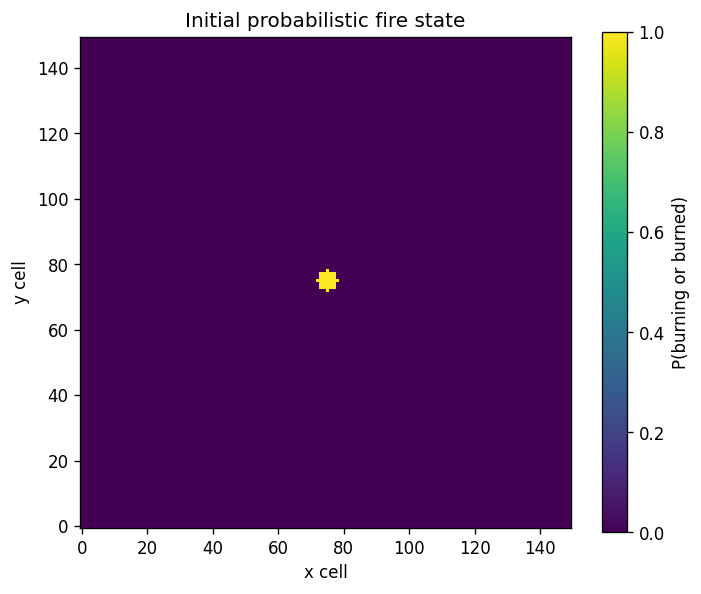

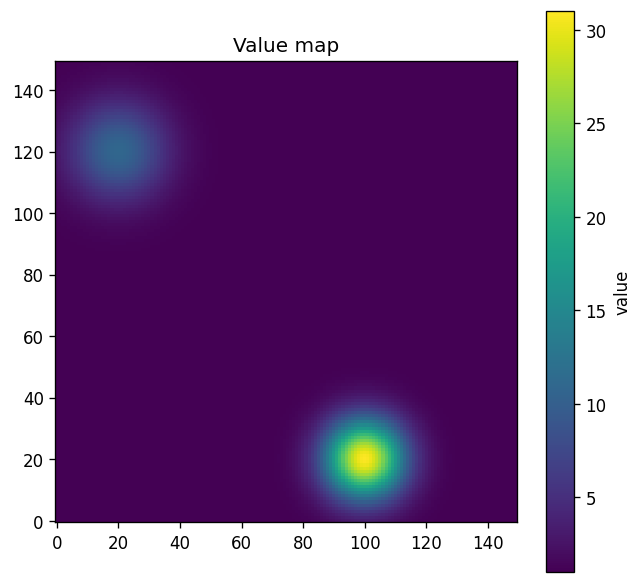

In [19]:
# Initial fire state (probabilistic via MC aggregation).

center = (nx // 2, ny // 2)
init_batch = model.init_state_batch(n_sims=60, center=center, radius_km=0.05)
init_state = model.aggregate_mc_to_state(init_batch)

model.plot_firestate(init_state, kind="p_affected", title="Initial probabilistic fire state")

plt.figure(figsize=(5.5, 5))
plt.imshow(value.T, origin="lower", aspect="equal", cmap="viridis")
plt.colorbar(label="value")
plt.title("Value map")
plt.tight_layout()
plt.show()


No drone_params
SR grid shape: (500, 150, 2)
Search mask coverage: 0.6242666666666666


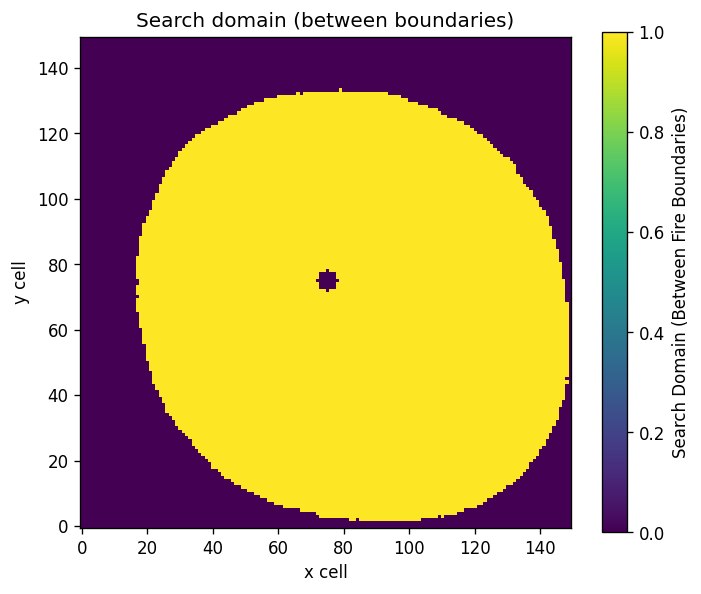

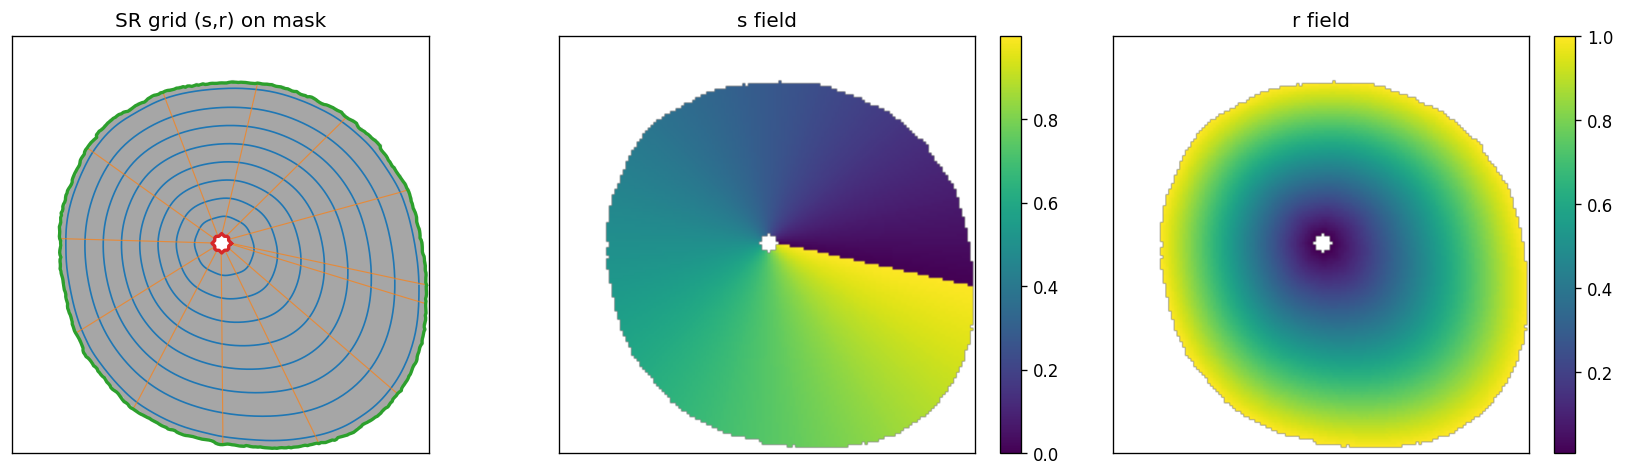

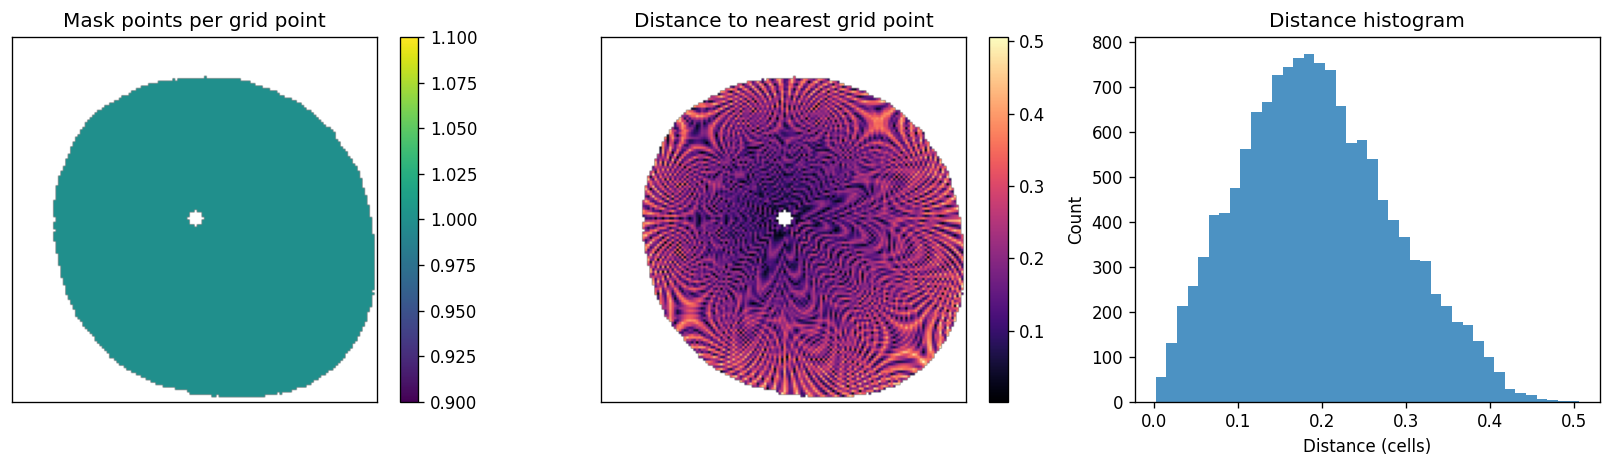

In [20]:
# Setup SR-native BO object and SR search grid.

bo = RetardantDropBayesOptSR(
    fire_model=model,
    init_firestate=init_state,
    n_drones=6,
    evolution_time_s=300.0,
    n_sims=60,
    fire_boundary_probability=0.5,
    search_grid_evolution_time_s=300.0,
)

bo.setup_search_grid_sr(
    K=500,
    boundary_field="affected",
    n_r=150,
    smooth_iters=300,
    omega=1.0,
)

print("SR grid shape:", bo.sr_grid.shape)
print("Search mask coverage:", float(np.mean(bo.search_domain_mask)))

model.plot_search_domain(bo.search_domain_mask, title="Search domain (between boundaries)")
bo.plot_sr_domain(show_fields=True, show_diagnostics=True)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo_sr.py:553: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


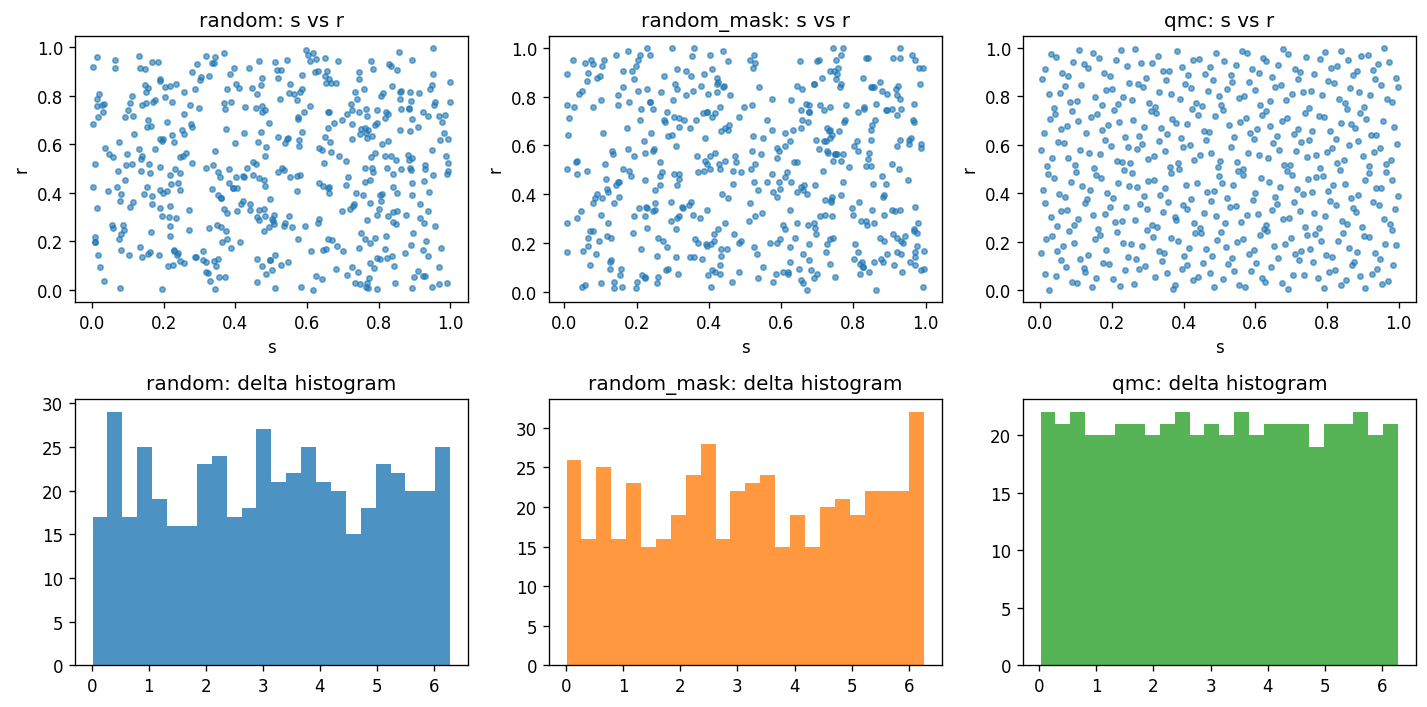

In [21]:
# SR sampling diagnostics (random, random_mask, qmc).

n_samples = 500

rand = bo.sample_random_theta(n_samples)
rand_mask = bo.sample_random_theta_on_mask(n_samples)
rand_qmc = bo.sample_qmc_theta(n_samples, method="sobol")

# For diagnostic plots we only inspect the first drone (index 0).

def extract_sr(theta):
    theta = np.atleast_2d(theta)
    s = theta[:, 0]
    r = theta[:, 1]
    delta = theta[:, 2] * (2.0 * np.pi)
    return s, r, delta

s_rand, r_rand, d_rand = extract_sr(rand)
s_mask, r_mask, d_mask = extract_sr(rand_mask)
s_qmc, r_qmc, d_qmc = extract_sr(rand_qmc)

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].scatter(s_rand, r_rand, s=10, alpha=0.6)
axes[0, 0].set_title("random: s vs r")
axes[0, 0].set_xlabel("s")
axes[0, 0].set_ylabel("r")

axes[0, 1].scatter(s_mask, r_mask, s=10, alpha=0.6)
axes[0, 1].set_title("random_mask: s vs r")
axes[0, 1].set_xlabel("s")
axes[0, 1].set_ylabel("r")

axes[0, 2].scatter(s_qmc, r_qmc, s=10, alpha=0.6)
axes[0, 2].set_title("qmc: s vs r")
axes[0, 2].set_xlabel("s")
axes[0, 2].set_ylabel("r")

axes[1, 0].hist(d_rand, bins=24, color="tab:blue", alpha=0.8)
axes[1, 0].set_title("random: delta histogram")

axes[1, 1].hist(d_mask, bins=24, color="tab:orange", alpha=0.8)
axes[1, 1].set_title("random_mask: delta histogram")

axes[1, 2].hist(d_qmc, bins=24, color="tab:green", alpha=0.8)
axes[1, 2].set_title("qmc: delta histogram")

plt.tight_layout()
plt.show()



Config: base
  sr_params: [[0.077 0.331 6.086]
 [0.452 0.336 5.728]
 [0.522 0.716 2.839]
 [0.669 0.257 5.781]
 [0.76  0.583 4.375]
 [0.818 0.6   0.   ]]
  xy_params: [[33.097 67.726  0.185]
 [54.835 81.815  4.032]
 [67.046 57.411  2.603]
 [80.226 31.247  3.558]
 [95.202 31.164  1.362]
 [98.725 81.265  6.1  ]]


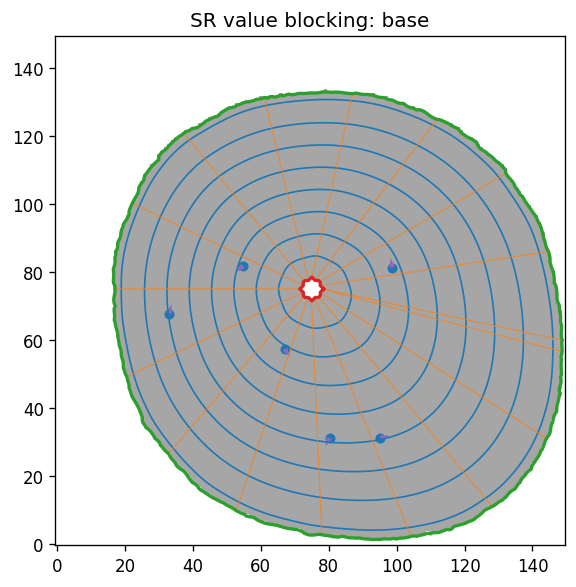

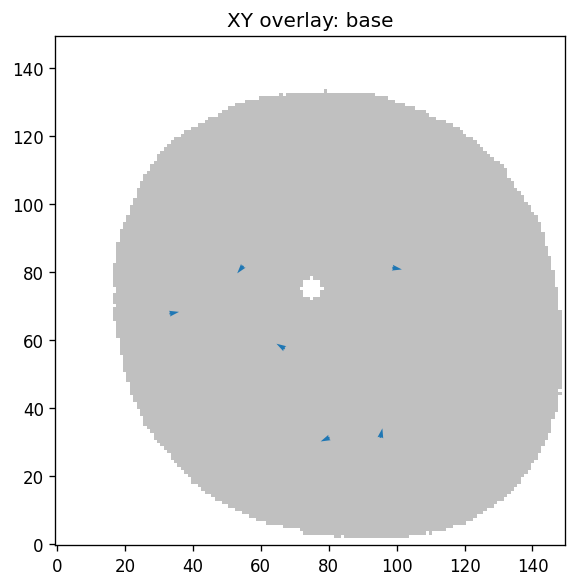

Applying retardant drop: D=[[33.097 67.726  0.185]
 [54.835 81.815  4.032]
 [67.046 57.411  2.603]
 [80.226 31.247  3.558]
 [95.202 31.164  1.362]
 [98.725 81.265  6.1  ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


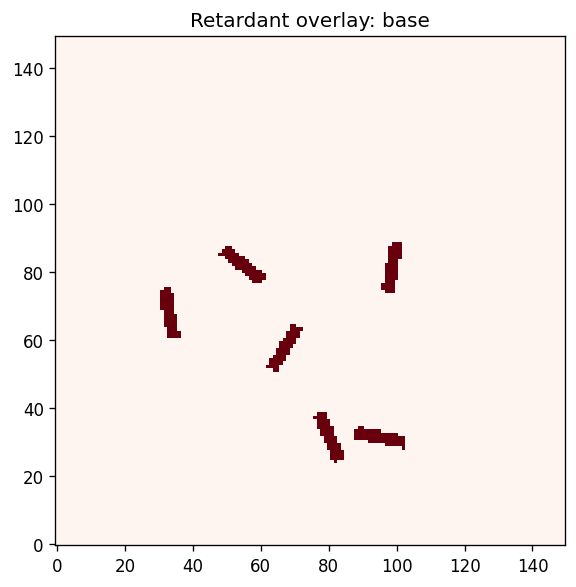

Applying retardant drop: D=[[33.097 67.726  0.185]
 [54.835 81.815  4.032]
 [67.046 57.411  2.603]
 [80.226 31.247  3.558]
 [95.202 31.164  1.362]
 [98.725 81.265  6.1  ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


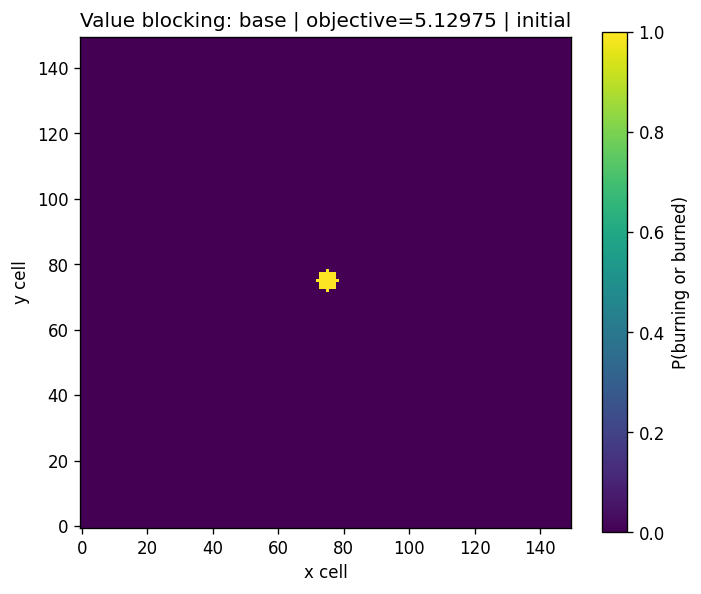

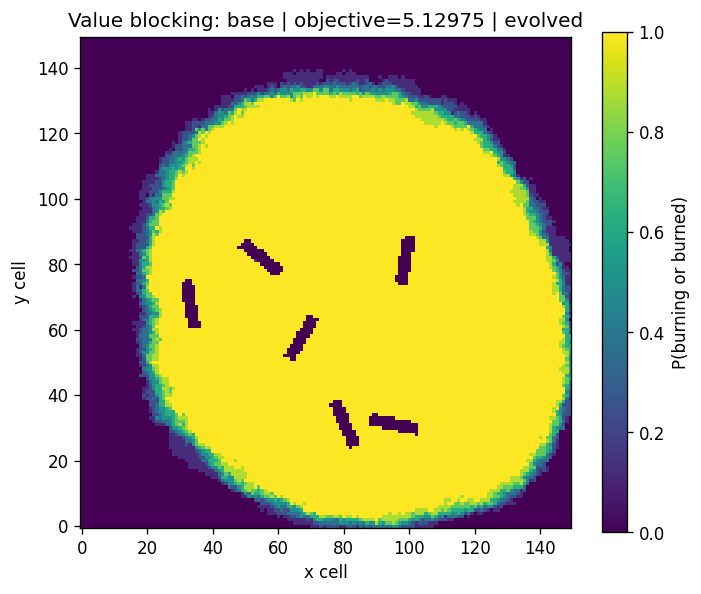

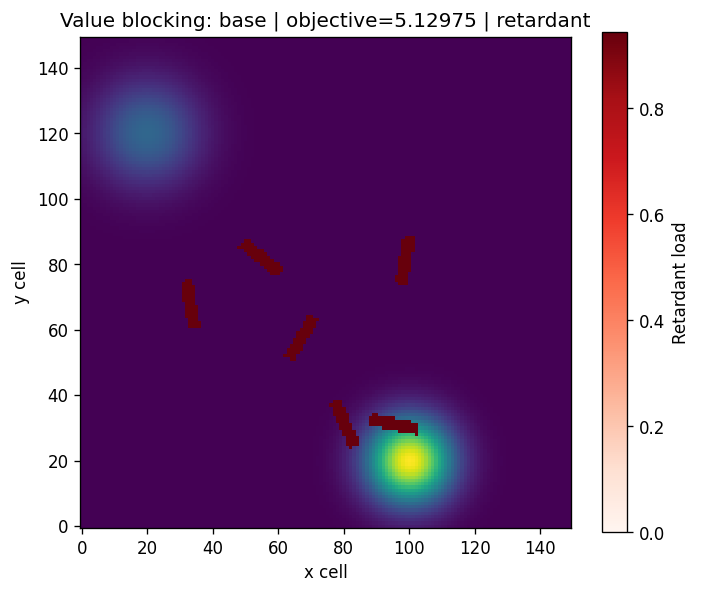


Config: outer_compact
  sr_params: [[0.81  0.8   0.   ]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]]
  xy_params: [[ 99.011  16.794   1.415]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]]


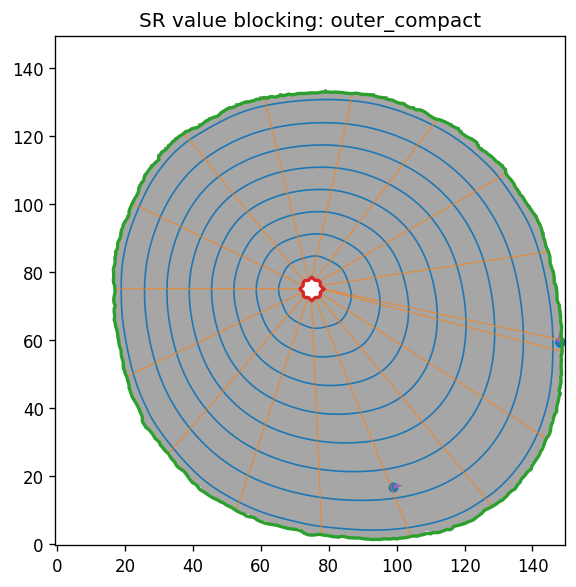

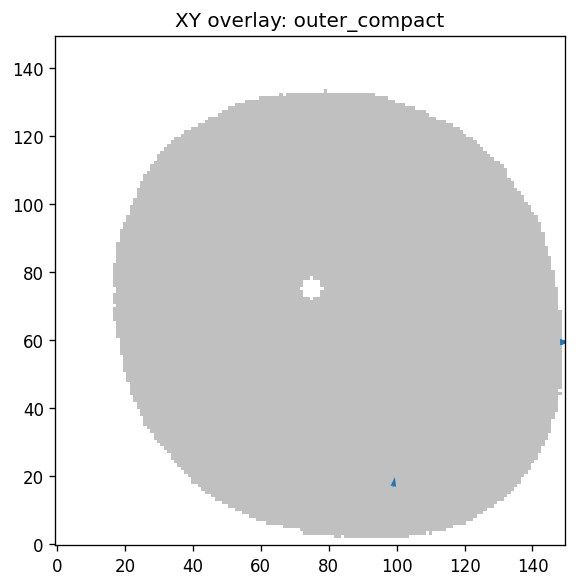

Applying retardant drop: D=[[ 99.011  16.794   1.415]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


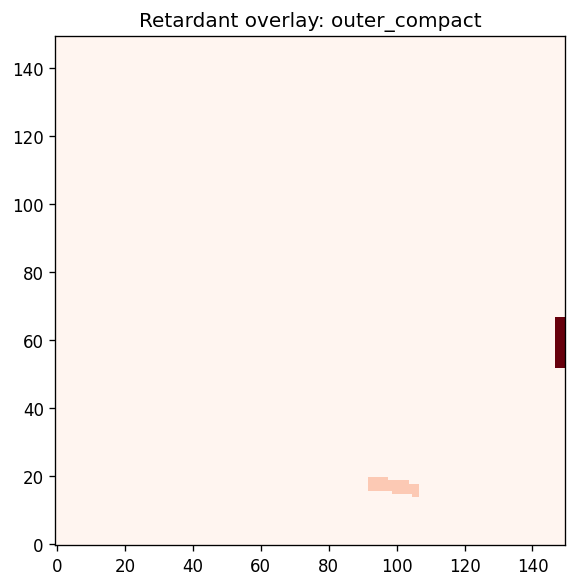

Applying retardant drop: D=[[ 99.011  16.794   1.415]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


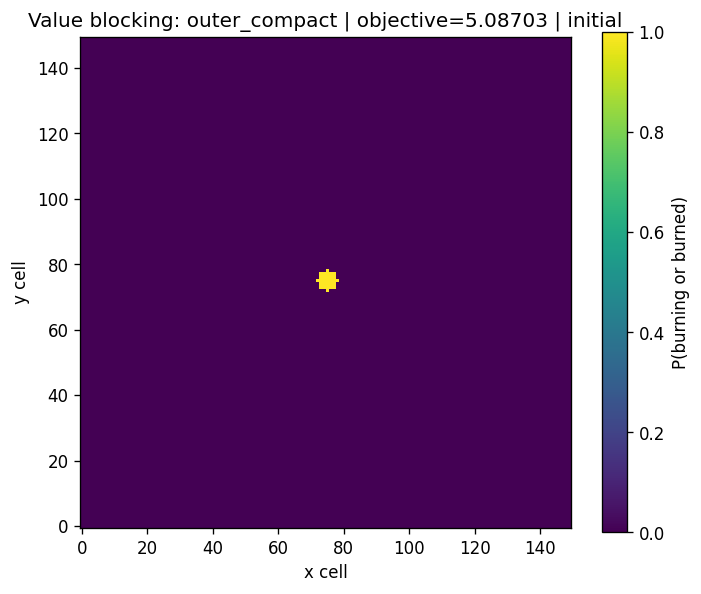

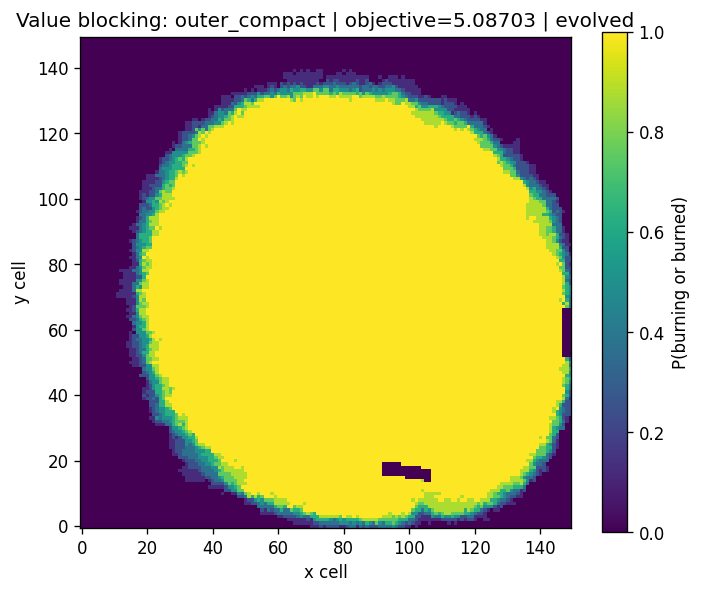

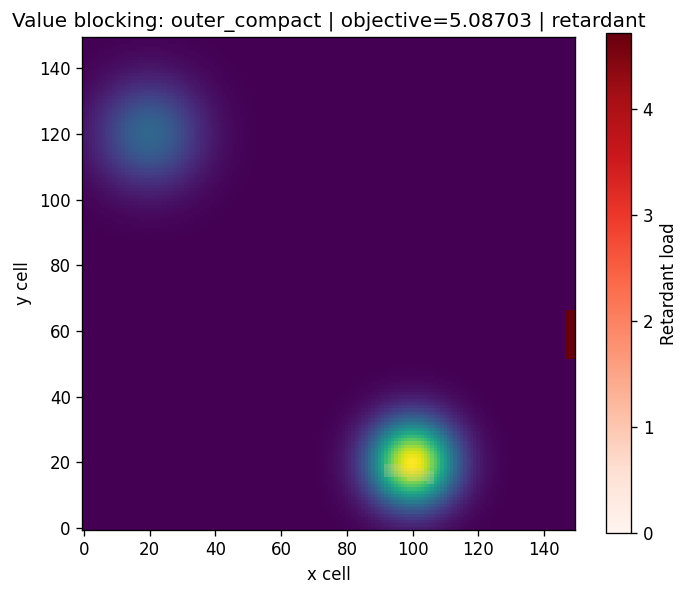


Config: loose_spacing
  sr_params: [[0.82  0.6   0.   ]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]]
  xy_params: [[ 95.699  31.272   1.35 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]]


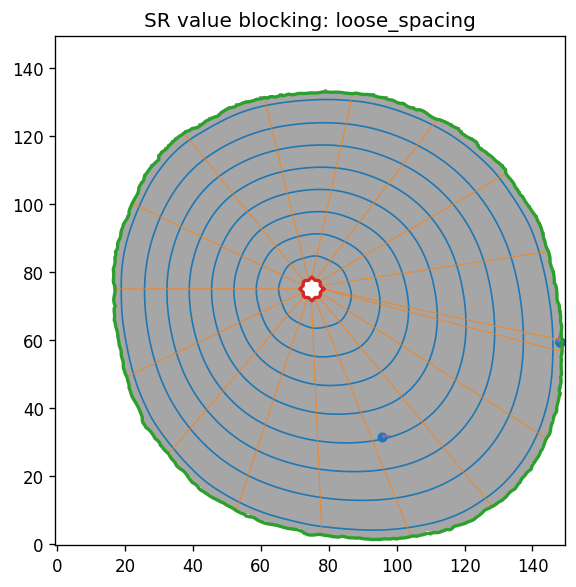

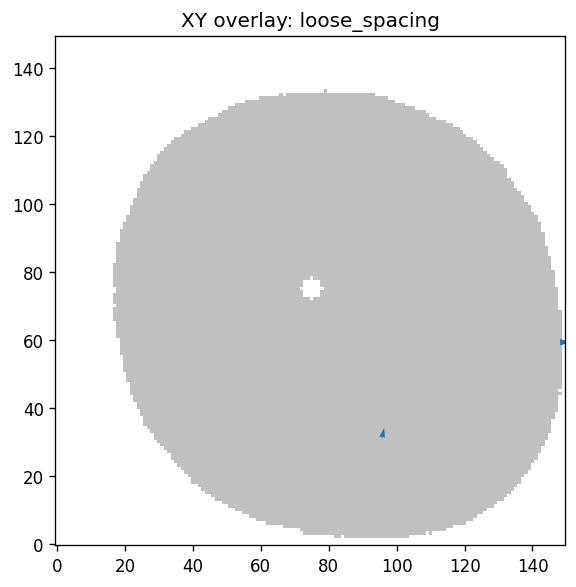

Applying retardant drop: D=[[ 95.699  31.272   1.35 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


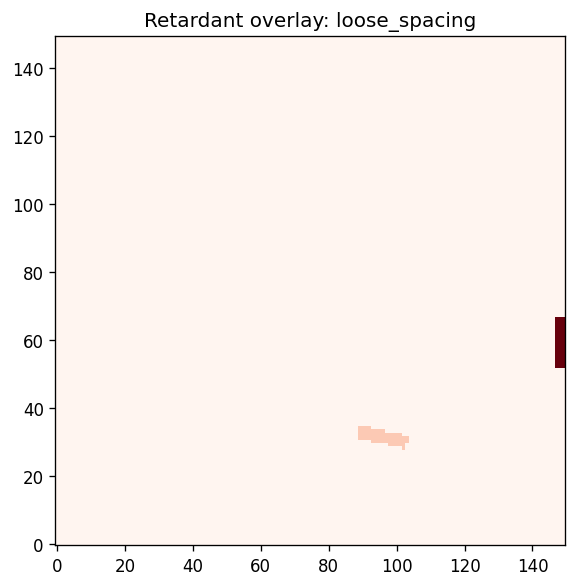

Applying retardant drop: D=[[ 95.699  31.272   1.35 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


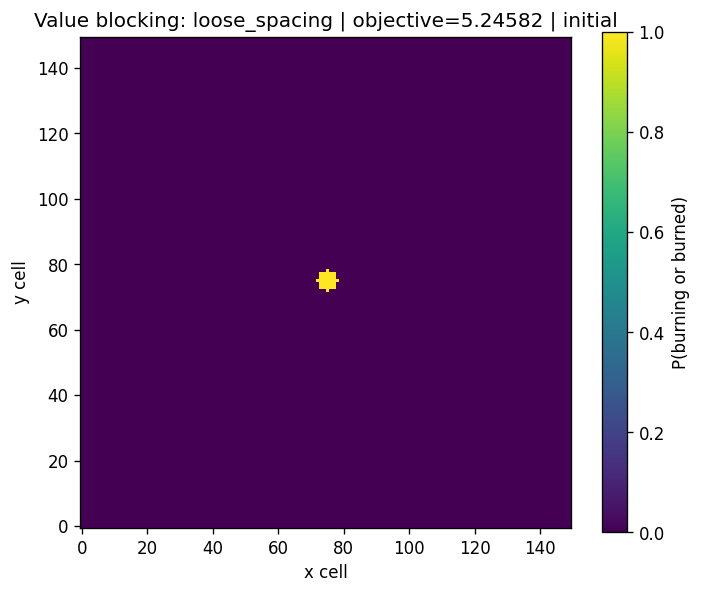

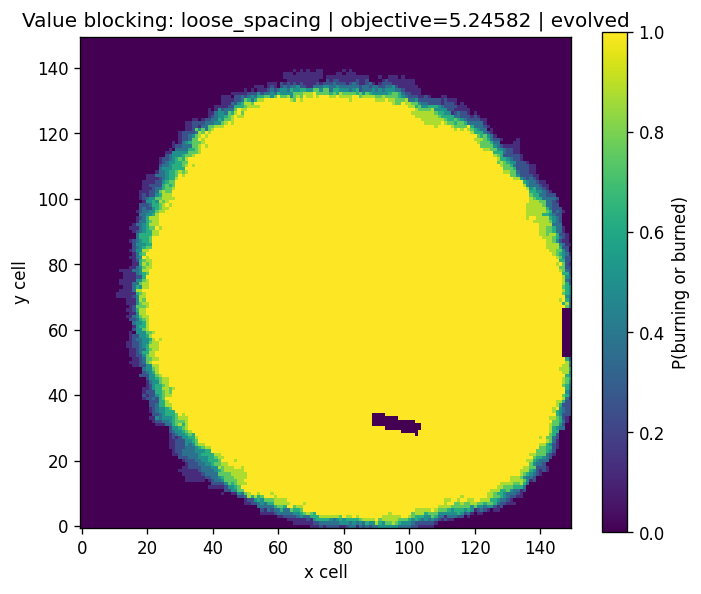

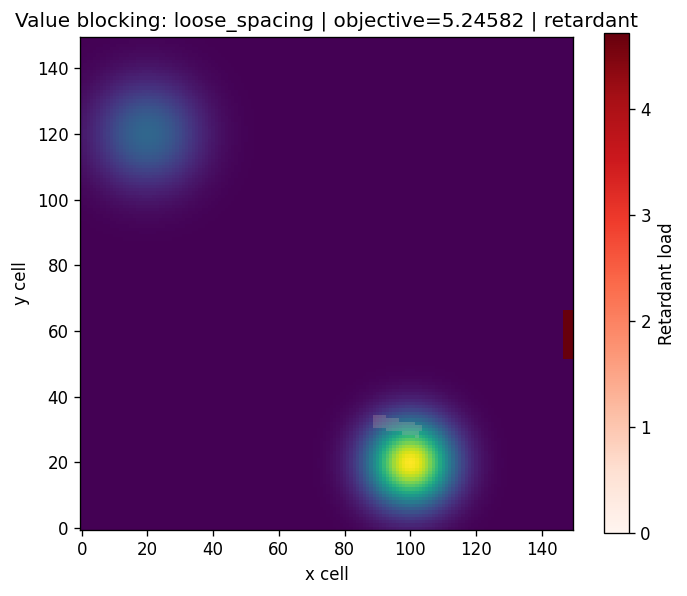


Config: value_weighted_r
  sr_params: [[0.814 0.752 0.   ]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]]
  xy_params: [[ 98.901  20.273   1.39 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]]


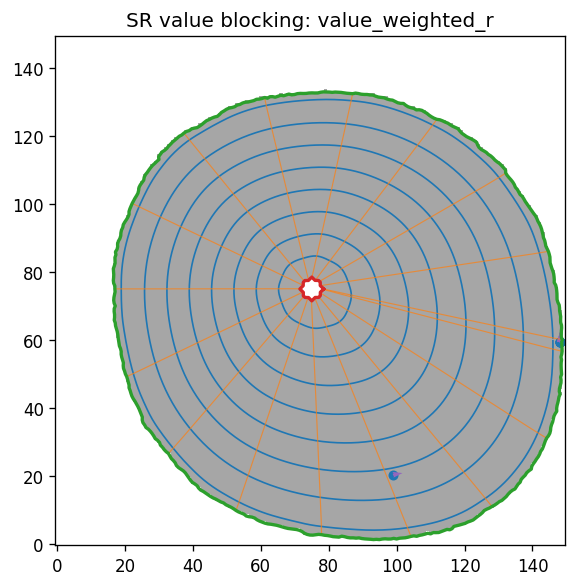

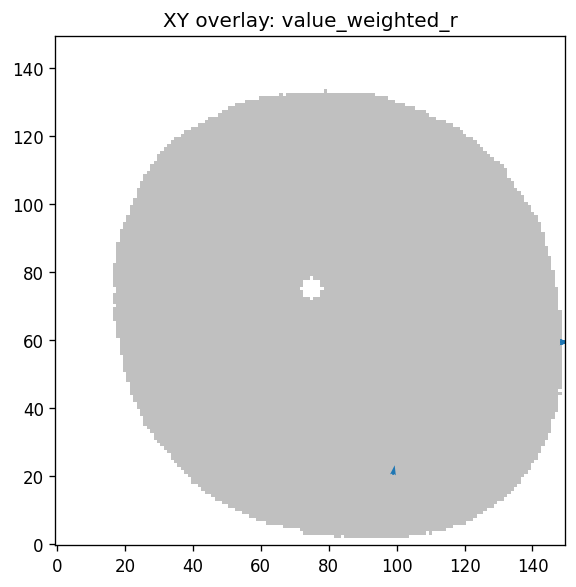

Applying retardant drop: D=[[ 98.901  20.273   1.39 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


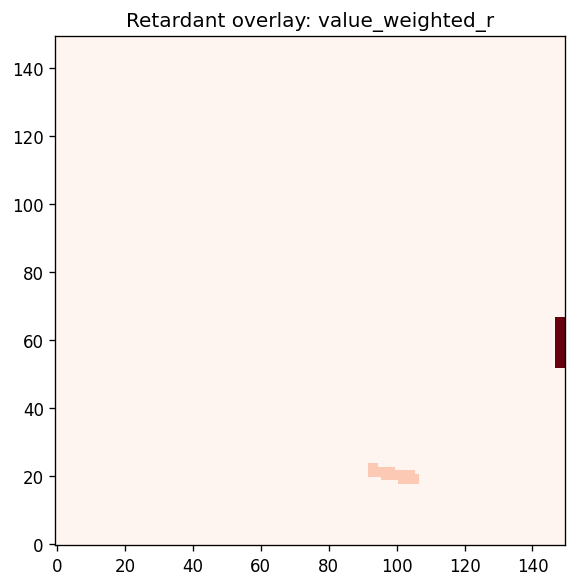

Applying retardant drop: D=[[ 98.901  20.273   1.39 ]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


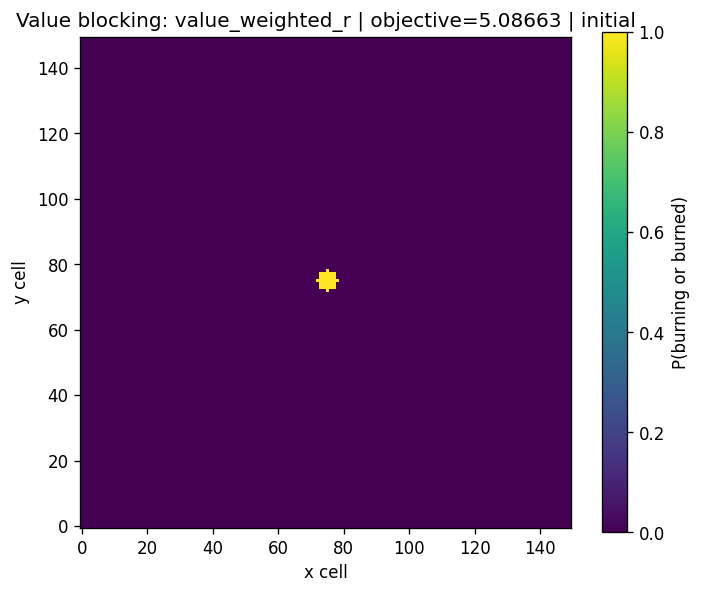

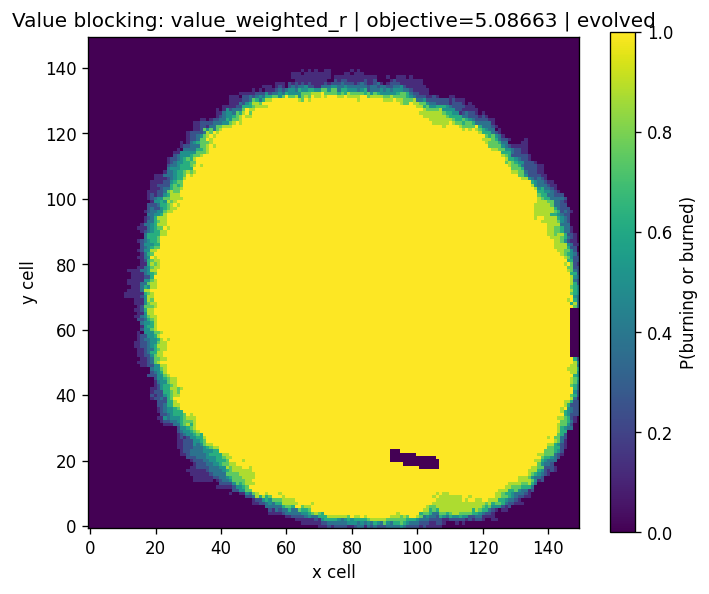

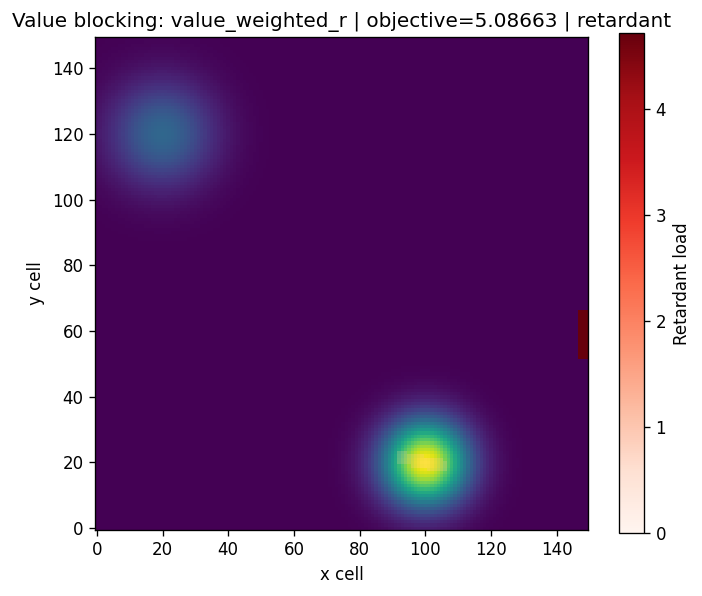


Config: offset_outward
  sr_params: [[0.814 0.902 0.   ]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]
 [1.    1.    6.283]]
  xy_params: [[103.415   9.981   1.395]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]]


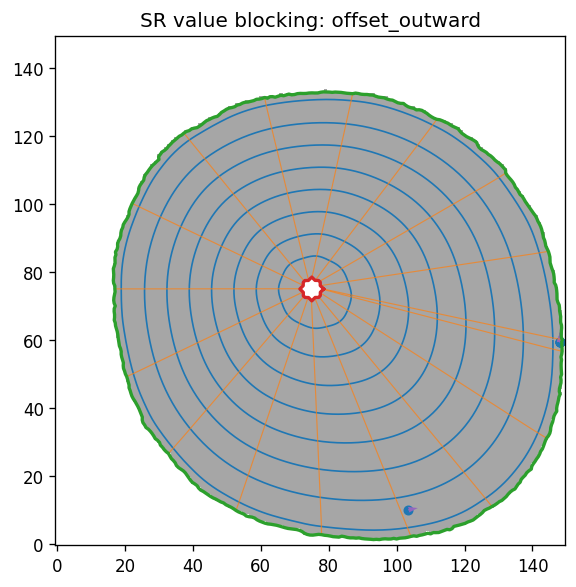

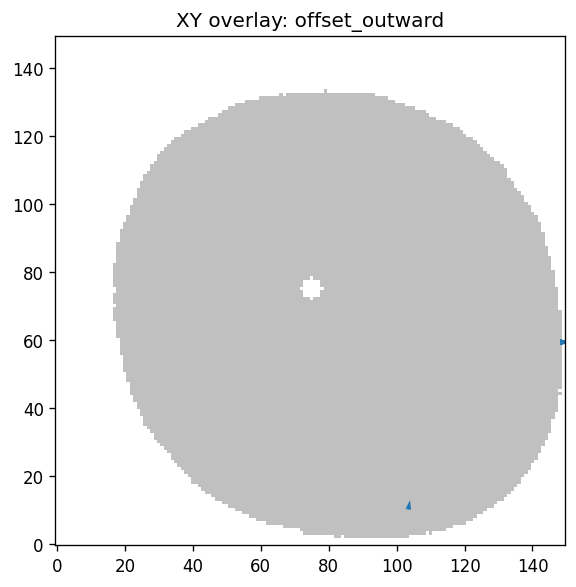

Applying retardant drop: D=[[103.415   9.981   1.395]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


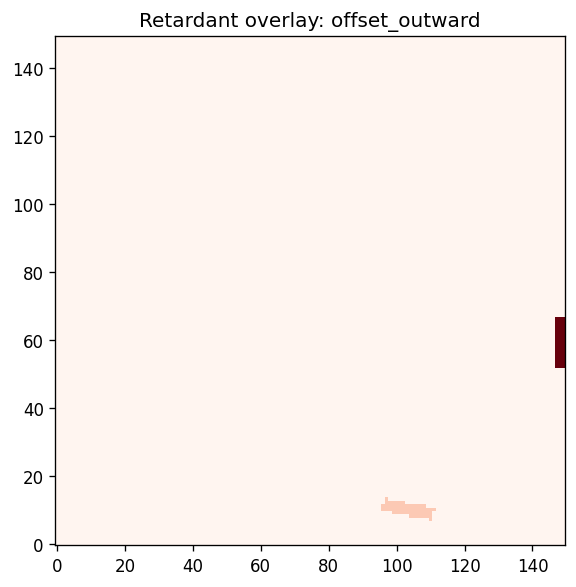

Applying retardant drop: D=[[103.415   9.981   1.395]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]
 [148.107  59.342   6.274]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


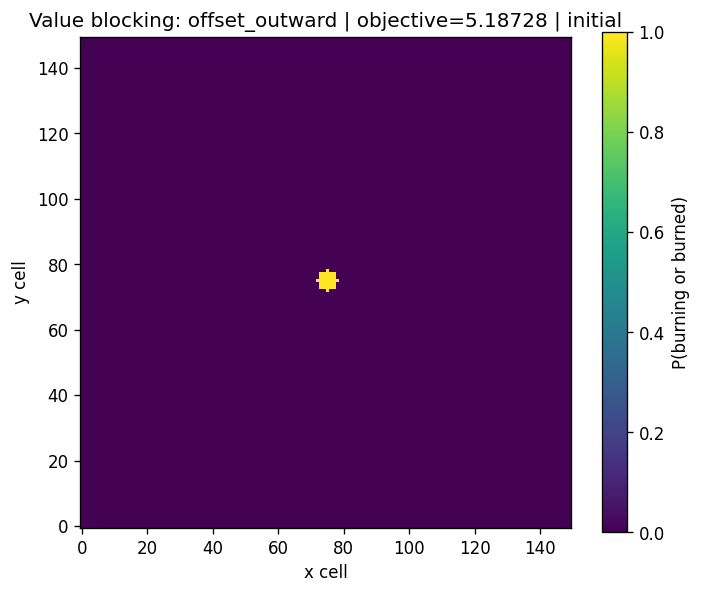

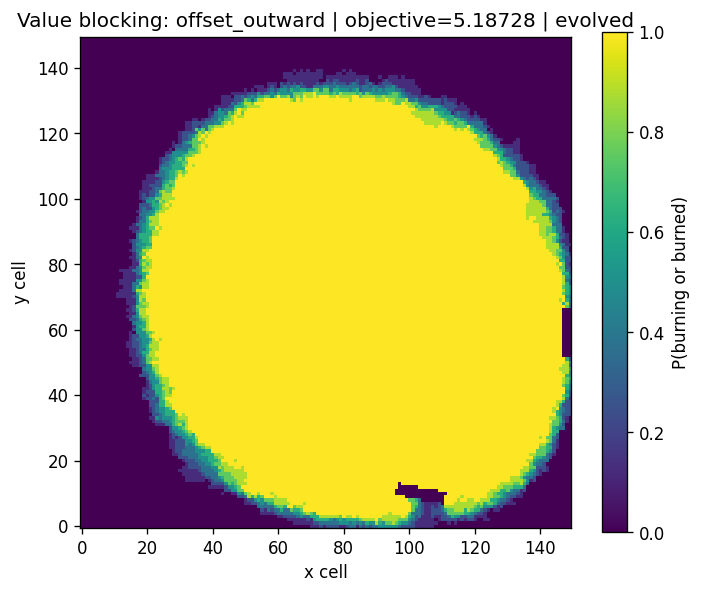

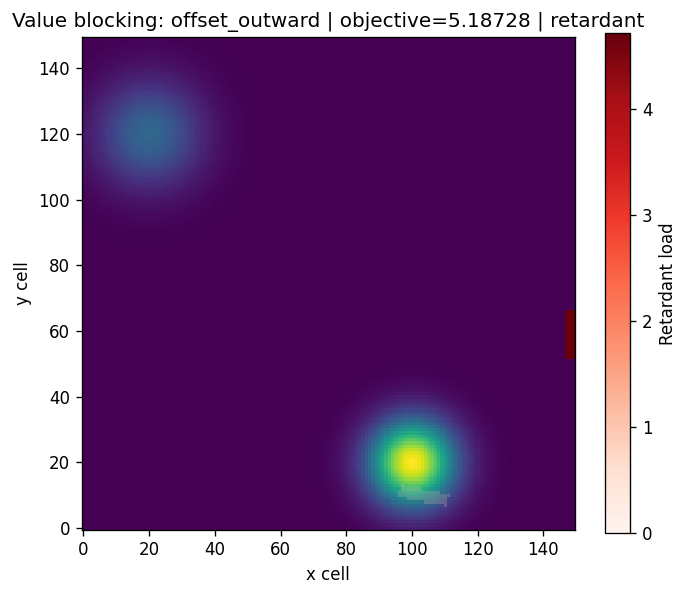


Config: weighted_peaks
  sr_params: [[0.046 0.6   0.   ]
 [0.346 0.6   0.   ]
 [0.512 0.6   0.   ]
 [0.734 0.6   0.   ]
 [0.83  0.6   0.   ]
 [0.954 0.6   0.   ]]
  xy_params: [[ 39.381  71.451   3.074]
 [ 57.766 106.146   4.256]
 [ 73.681  31.256   1.773]
 [ 98.152  31.909   1.282]
 [118.331  77.888   6.051]
 [118.652  53.829   0.249]]


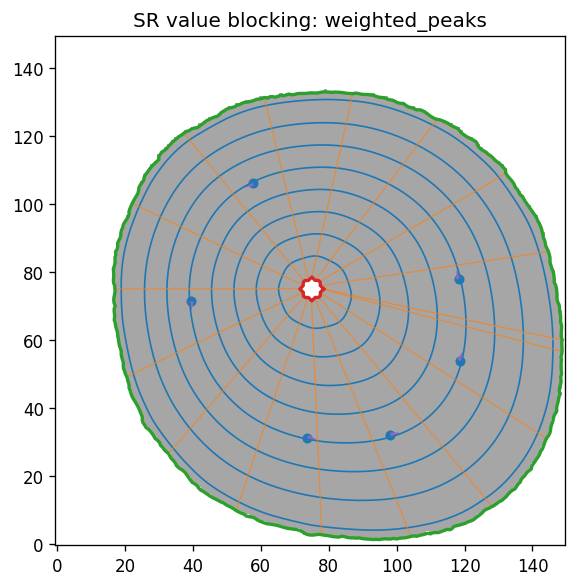

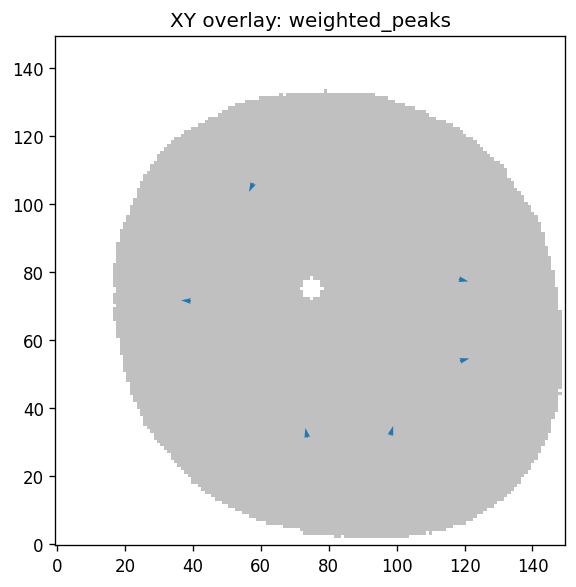

Applying retardant drop: D=[[ 39.381  71.451   3.074]
 [ 57.766 106.146   4.256]
 [ 73.681  31.256   1.773]
 [ 98.152  31.909   1.282]
 [118.331  77.888   6.051]
 [118.652  53.829   0.249]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


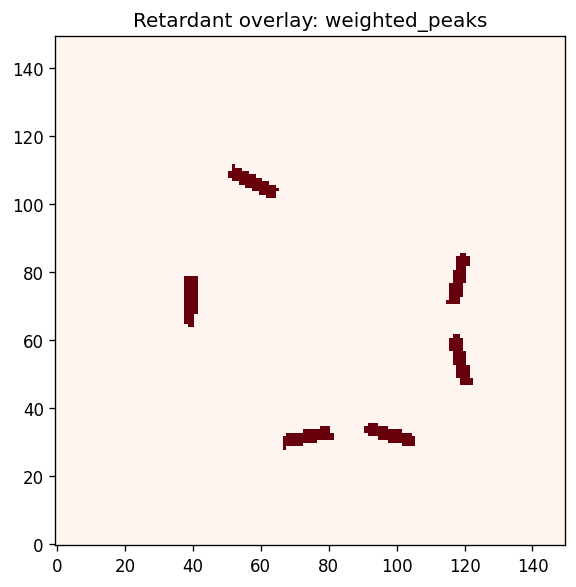

Applying retardant drop: D=[[ 39.381  71.451   3.074]
 [ 57.766 106.146   4.256]
 [ 73.681  31.256   1.773]
 [ 98.152  31.909   1.282]
 [118.331  77.888   6.051]
 [118.652  53.829   0.249]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2


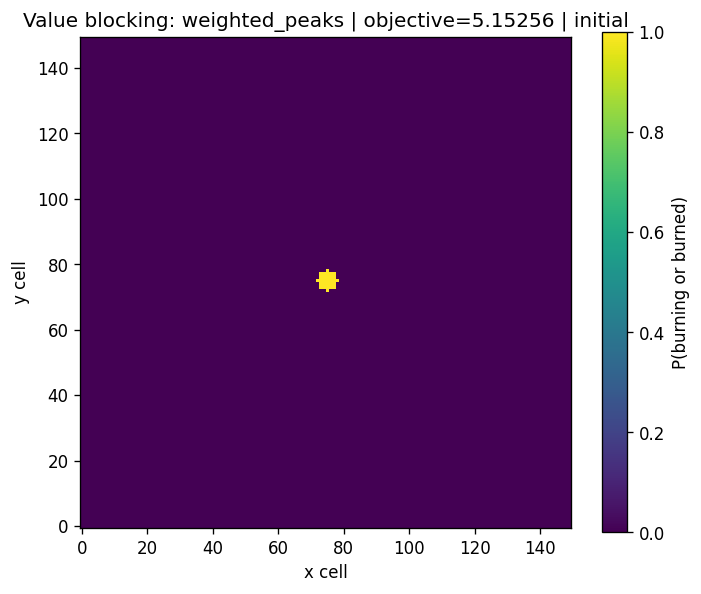

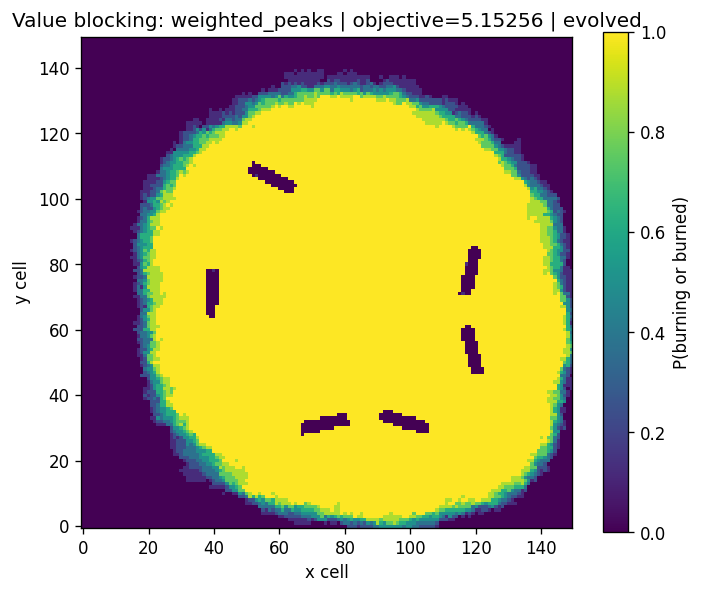

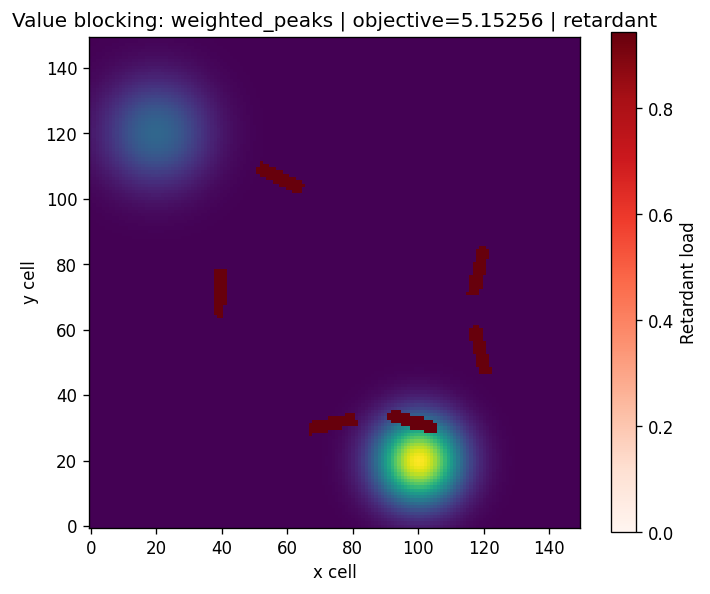

In [22]:
# Value-blocking heuristic tests (multiple setups).

cell_size_km = model.env.domain_km / nx
width_cells = model.env.drop_w_km / cell_size_km
min_spacing = 2.0 * width_cells

configs = [
    {"name": "base", "r_value": 0.60, "compactness": 0.25, "min_spacing": min_spacing, "selection": "greedy", "value_power": 1.0, "r_offset": 0.0, "value_offset": value_background},
    {"name": "outer_compact", "r_value": 0.80, "compactness": 0.20, "min_spacing": min_spacing, "selection": "greedy", "value_power": 1.0, "r_offset": 0.0, "value_offset": value_background},
    {"name": "loose_spacing", "r_value": 0.60, "compactness": 0.35, "min_spacing": 3.0 * width_cells, "selection": "greedy", "value_power": 1.0, "r_offset": 0.0, "value_offset": value_background},
    {"name": "value_weighted_r", "r_value": None, "compactness": 0.25, "min_spacing": min_spacing, "selection": "greedy", "value_power": 1.0, "r_offset": 0.0, "value_offset": value_background},
    {"name": "offset_outward", "r_value": None, "compactness": 0.25, "min_spacing": min_spacing, "selection": "greedy", "value_power": 1.0, "r_offset": 0.15, "value_offset": value_background},
    {"name": "weighted_peaks", "r_value": 0.60, "compactness": 0.25, "min_spacing": min_spacing, "selection": "weighted", "value_power": 2.0, "r_offset": 0.0, "value_offset": value_background},
]

plot_n_sims = 8

for cfg in configs:
    placements = bo._sr_value_blocking(
        r_value=cfg["r_value"],
        count=bo.n_drones,
        compactness=cfg["compactness"],
        min_spacing=cfg["min_spacing"],
        min_arc_sep_frac=None,
        value_power=cfg["value_power"],
        value_offset=cfg.get("value_offset"),
        selection=cfg["selection"],
        r_offset=cfg["r_offset"],
    )

    theta = bo._encode_sr_params(np.asarray(placements, dtype=float))
    sr_params = bo.decode_theta_sr(theta)
    xy_params = bo.decode_theta(theta)

    print("\n" + f"Config: {cfg['name']}")
    print("  sr_params:", sr_params)
    print("  xy_params:", xy_params)

    plot_sr_points(bo, sr_params, f"SR value blocking: {cfg['name']}")
    plot_drop_overlay(bo.search_domain_mask, xy_params, f"XY overlay: {cfg['name']}")
    render_retardant(model, xy_params, f"Retardant overlay: {cfg['name']}")

    _ = bo.plot_evolved_firestate(theta, n_sims=plot_n_sims, title_prefix=f"Value blocking: {cfg['name']}")


In [23]:
# Heuristic-only optimization (value blocking only).

heuristic_kwargs = {
    "r_value": 0.60,
    "compactness": 0.25,
    "min_spacing": min_spacing,
    "min_arc_sep_frac": 0.25,
    "value_power": 1.0,
    "value_offset": value_background,
    "selection": "greedy",
    "r_offset": 0.0,
}

best_theta, best_params, best_y, (X_feats, y_vals), y_nexts, y_bests = bo.run_heuristic_search(
    n_evals=25,
    K_grid=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
    heuristic_random_frac=0.2,
    heuristic_kwargs=heuristic_kwargs,
    verbose=True,
    print_every=5,
)

plt.figure(figsize=(6, 4))
plt.plot(y_bests, marker="o")
plt.xlabel("iteration")
plt.ylabel("best_y")
plt.title("Heuristic (SR) best objective")
plt.tight_layout()
plt.show()

plot_drop_overlay(bo.search_domain_mask, best_params, "Heuristic best (x,y,phi)")
render_retardant(model, best_params, "Heuristic best retardant overlay")
_ = bo.plot_evolved_firestate(best_theta, n_sims=10, title_prefix="Heuristic best")


Applying retardant drop: D=[[ 23.015  87.134   5.892]
 [ 59.923  70.758   1.553]
 [ 87.259  46.77    4.455]
 [ 93.87  102.61    3.136]
 [ 95.202  31.164   1.362]
 [113.607 120.694   4.2  ]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
[Heuristic SR] eval 001/25 | y=5.0553 | best=5.0553
              (s,r,delta) per drone:
              [[0.176 0.953 1.039]
 [0.19  0.523 2.027]
 [0.464 0.919 3.759]
 [0.538 0.228 1.346]
 [0.814 0.369 3.203]
 [0.818 0.6   0.   ]]
              (x,y,phi) per drone:
              [[ 23.015  87.134   5.892]
 [ 59.923  70.758   1.553]
 [ 87.259  46.77    4.455]
 [ 93.87  102.61    3.136]
 [ 95.202  31.164   1.362]
 [113.607 120.694   4.2  ]]
Applying retardant drop: D=[[ 69.127  72.812   1.556]
 [ 71.394  79.385   6.006]
 [ 78.144  84.695   2.033]
 [ 79.619 119.934   5.46 ]
 [ 95.202  31.164   1.362]
 [107.725  73.524   2.831]], amount=1.0, drop_w_km=0.05, drop_h_km=0.2
Applying retardant drop: D=[[ 35.466  45.212   5.322]
 [ 65.732  49.285   4.659]
 [ 79.095 1

KeyboardInterrupt: 

In [ ]:
# BO in SR space (SR-native features and kernel).

best_theta, best_params, best_y, (X_feats, y_vals), y_nexts, y_bests = bo.run_bayes_opt(
    n_init=20,
    n_iters=80,
    n_candidates=1500,
    xi=0.01,
    K_grid=300,
    boundary_field="affected",
    n_r=120,
    smooth_iters=300,
    omega=1.0,
    verbose=True,
    print_every=10,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.2,
    init_heuristic_kwargs=heuristic_kwargs,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_global_masked=True,
    candidate_local_frac=0.5,
    candidate_local_top_k=5,
    candidate_local_sigma_s=0.05,
    candidate_local_sigma_r=0.05,
    candidate_local_sigma_delta_rad=np.deg2rad(12.0),
    candidate_local_resample_delta_prob=0.05,
)

plt.figure(figsize=(6, 4))
plt.plot(y_bests, marker="o")
plt.xlabel("iteration")
plt.ylabel("best_y")
plt.title("BO (SR) best objective")
plt.tight_layout()
plt.show()

plot_drop_overlay(bo.search_domain_mask, best_params, "BO best (x,y,phi)")
render_retardant(model, best_params, "BO best retardant overlay")
_ = bo.plot_evolved_firestate(best_theta, n_sims=10, title_prefix="BO best")
